In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [15]:
df = pd.read_csv("/home/mohamed/Sales-Forecasting-and-Demand-Prediction/1000000_Sales_Records.csv")
df.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,7/27/2012,443368995,7/28/2012,1593,9.33,6.92,14862.69,11023.56,3839.13
1,Middle East and North Africa,Morocco,Clothes,Online,M,9/14/2013,667593514,10/19/2013,4611,109.28,35.84,503890.08,165258.24,338631.84
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,5/15/2015,940995585,6/4/2015,360,421.89,364.69,151880.40,131288.40,20592.00
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,5/17/2017,880811536,7/2/2017,562,109.28,35.84,61415.36,20142.08,41273.28
4,Europe,Slovakia,Beverages,Offline,L,10/26/2016,174590194,12/4/2016,3973,47.45,31.79,188518.85,126301.67,62217.18


In [30]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df=df.sort_values(by='Order Date',ascending=True)
df.head()

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
259150,Asia,Thailand,Baby Food,Online,M,2010-01-01,433514773,2010-01-08,5510,255.28,159.42,1406592.80,878404.20,528188.60
855219,Central America and the Caribbean,Saint Kitts and Nevis,Personal Care,Offline,H,2010-01-01,127939069,2010-02-05,8868,81.73,56.67,724781.64,502549.56,222232.08
603384,Europe,Italy,Baby Food,Online,M,2010-01-01,610192954,2010-02-19,8510,255.28,159.42,2172432.80,1356664.20,815768.60
223432,Middle East and North Africa,Turkey,Personal Care,Online,L,2010-01-01,335788810,2010-02-11,6226,81.73,56.67,508850.98,352827.42,156023.56
712508,Sub-Saharan Africa,Sierra Leone,Beverages,Online,H,2010-01-01,872081267,2010-01-12,7081,47.45,31.79,335993.45,225104.99,110888.46


In [17]:
df.describe()

,Order Date,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
count,1000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1.000000e+06
mean,2013-10-14 22:41:24.979199488,5.493520e+08,4998.867302,266.025488,187.522978,1.329563e+06,9.372671e+05,3.922956e+05
min,2010-01-01 00:00:00,1.000012e+08,1.000000,9.330000,6.920000,9.330000e+00,6.920000e+00,2.410000e+00
25%,2011-11-22 00:00:00,3.239629e+08,2502.000000,81.730000,35.840000,2.778672e+05,1.617289e+05,9.510480e+04
50%,2013-10-15 00:00:00,5.486524e+08,4998.000000,154.060000,97.440000,7.844445e+05,4.667818e+05,2.810549e+05
75%,2015-09-08 00:00:00,7.745981e+08,7496.000000,421.890000,263.330000,1.822444e+06,1.196327e+06,5.653076e+05
max,2017-07-29 00:00:00,9.999999e+08,10000.000000,668.270000,524.960000,6.682700e+06,5.249600e+06,1.738700e+06
std,NaN,2.599397e+08,2885.334142,216.987966,175.650798,1.468527e+06,1.148954e+06,3.788199e+05


In [18]:
df.duplicated().sum()

50009

In [20]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [26]:
df_objects=df.select_dtypes(include=["object"])
df_objects.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Ship Date'],
      dtype='object')

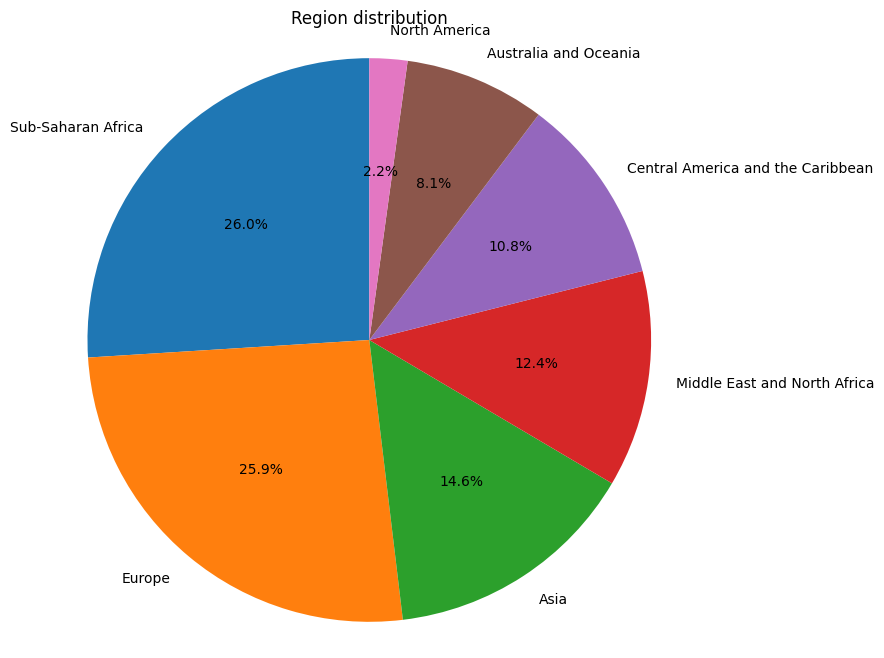

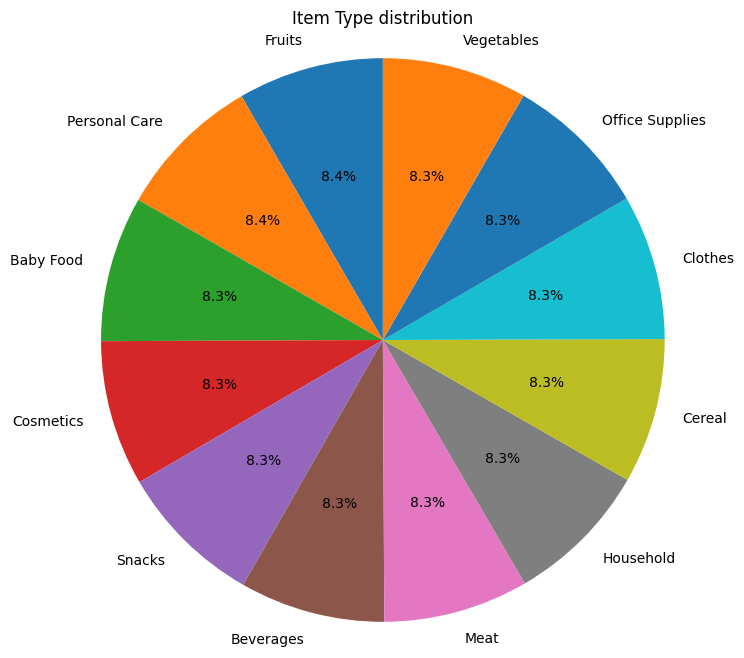

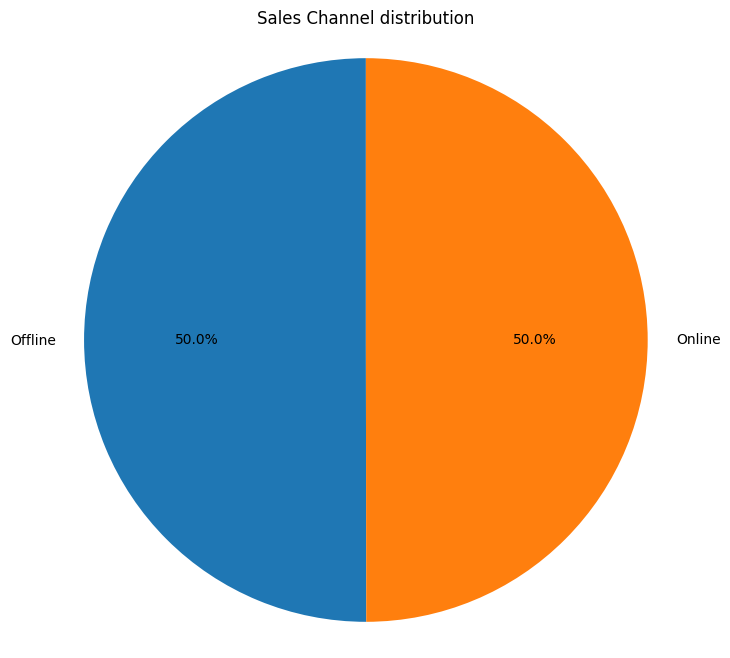

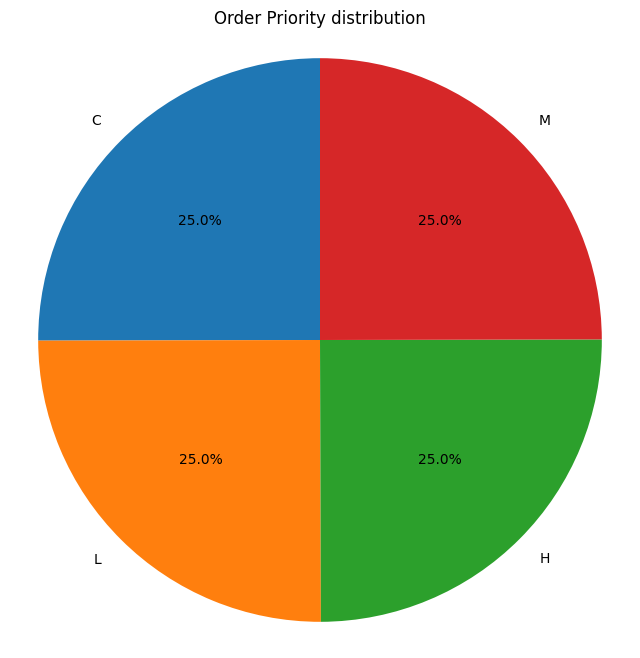

In [28]:
for i in (df_objects.columns[[0,2,3,4]]):
    x = df[i].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(x, labels=x.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"{i} distribution")
    plt.axis('equal')
    plt.show()


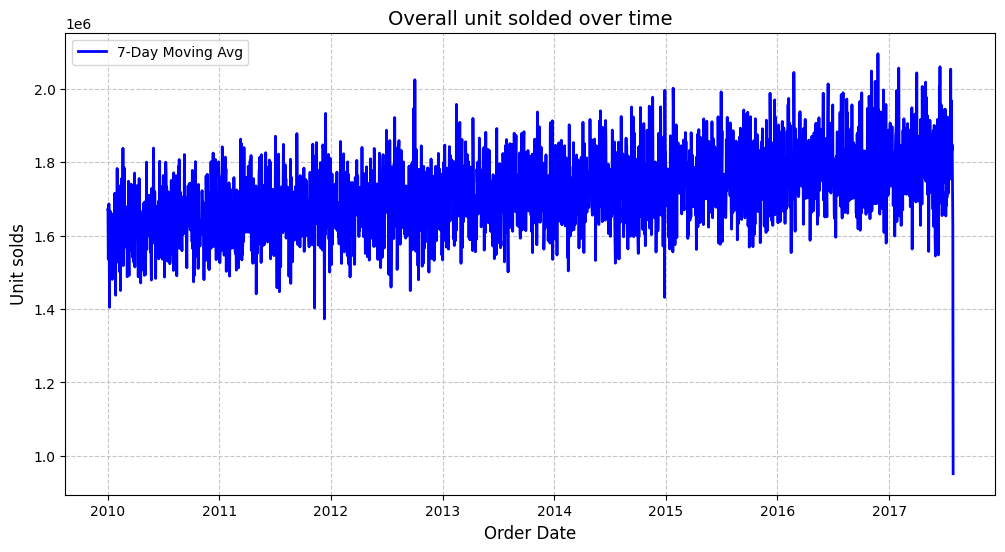

In [29]:
sales_frequency = df.groupby('Order Date')['Units Sold'].sum().reset_index()
sales_frequency['Smoothed_frequency'] = sales_frequency['Units Sold'].rolling(window=7).mean()  # 7-day moving average
plt.figure(figsize=(12, 6))
plt.plot(sales_frequency['Order Date'], sales_frequency['Units Sold'], color='blue', linewidth=2, label="7-Day Moving Avg")
plt.title('Overall unit solded over time', fontsize=14)
plt.xlabel('Order Date', fontsize=12)
plt.ylabel('Unit solds', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

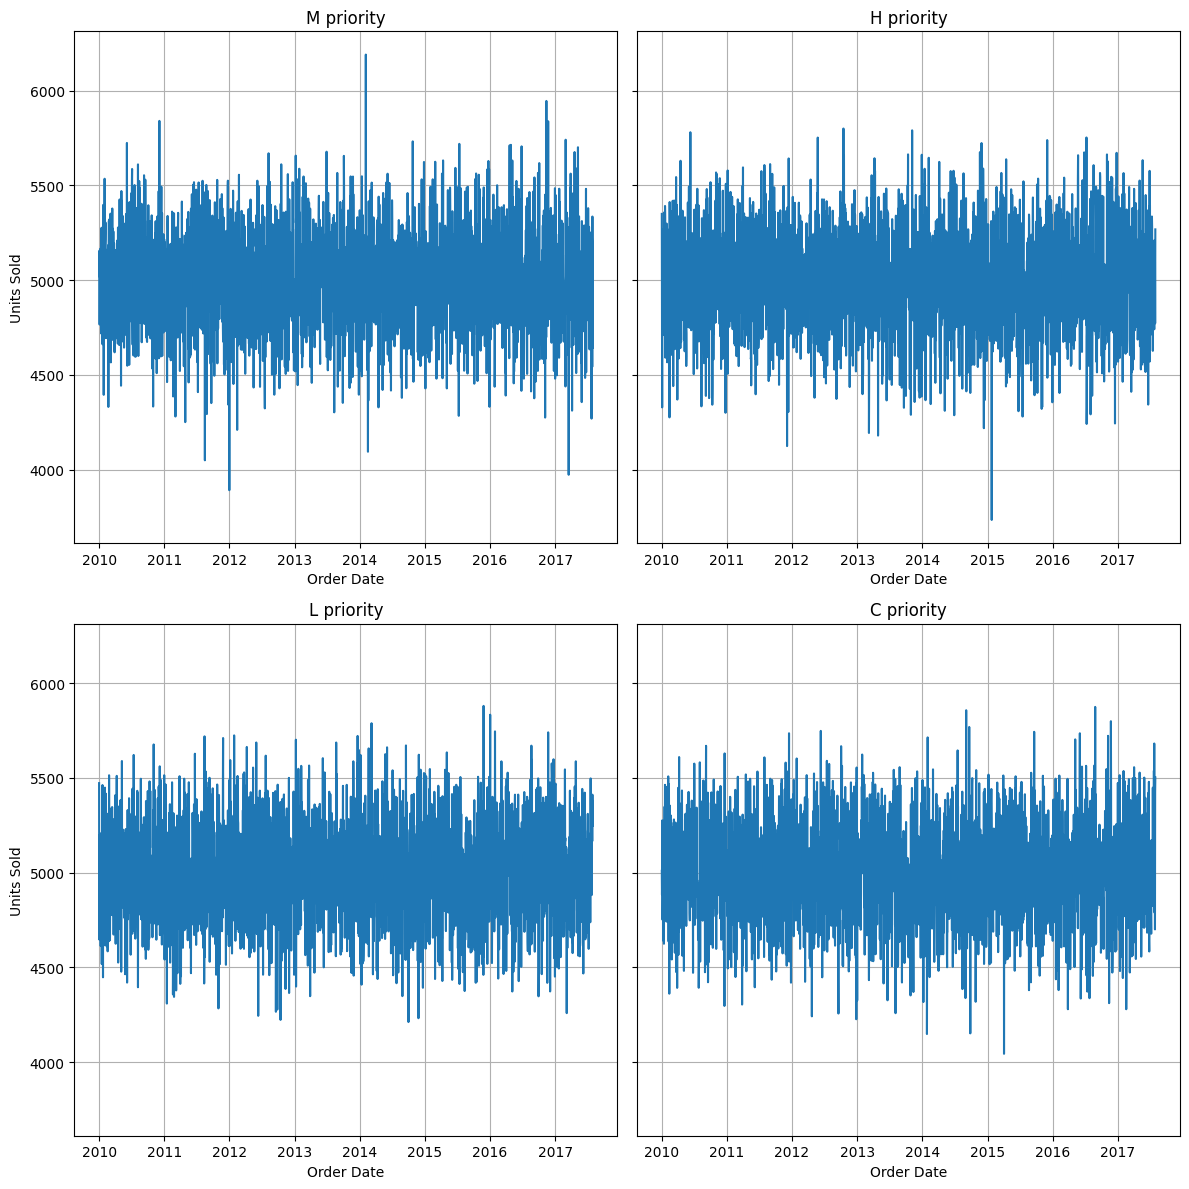

In [31]:
pirorites = df['Order Priority'].unique()
num_pirorites = len(pirorites)
num_rows = (num_pirorites + 1) // 2  
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows), sharey=True)
axes = axes.flatten()
for ax, priority in zip(axes, pirorites):
    priority_data = df[df['Order Priority'] == priority]
    sns.lineplot(data=priority_data, x='Order Date', y='Units Sold', ax=ax, errorbar=None)
    ax.set_title(f'{priority} priority')
    ax.set_xlabel('Order Date')
    ax.set_ylabel('Units Sold')
    ax.grid(True)
plt.tight_layout()
plt.show()

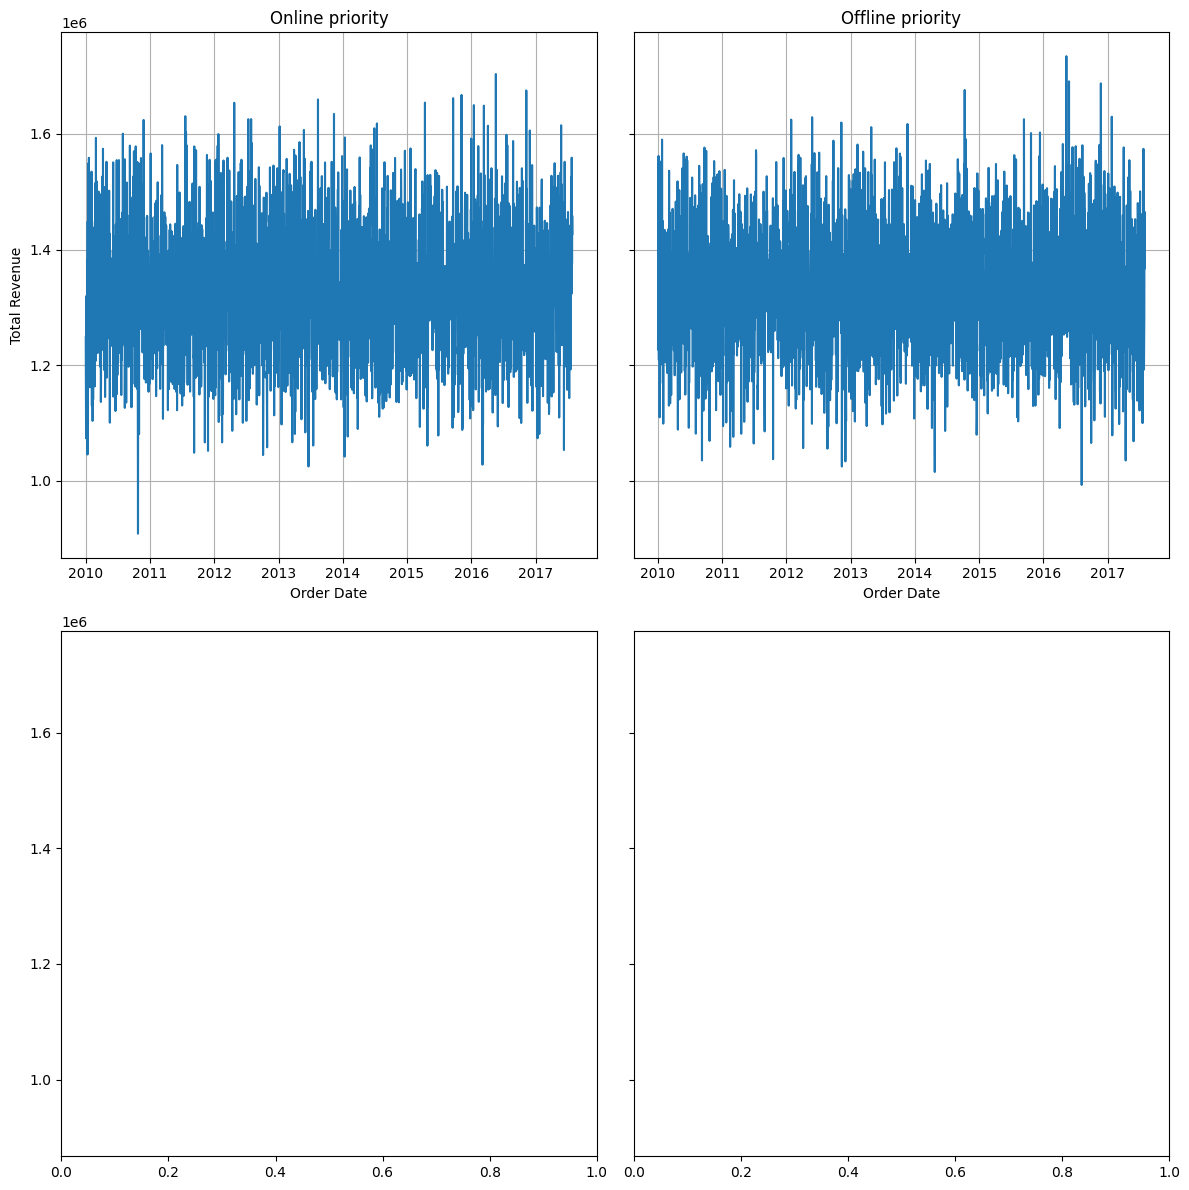

In [33]:
sales_channel = df['Sales Channel'].unique()
num_sales_channel = len(pirorites)
num_rows = (num_sales_channel + 1) // 2  
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 6 * num_rows), sharey=True)
axes = axes.flatten()
for ax, priority in zip(axes, sales_channel):
    priority_data = df[df['Sales Channel'] == priority]
    sns.lineplot(data=priority_data, x='Order Date', y='Total Revenue', ax=ax, errorbar=None)
    ax.set_title(f'{priority} priority')
    ax.set_xlabel('Order Date')
    ax.set_ylabel('Total Revenue')
    ax.grid(True)
plt.tight_layout()
plt.show()